In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import zscore
from scipy.stats import boxcox
import scipy.stats as stats
import torch
%matplotlib inline

In [34]:
idx = 31

In [35]:
import sys
sys.path.append("..") 
sys.path.append("../..") 
import torch
import numpy as np
import torch.nn.functional as F
import json

import hydra
from omegaconf import DictConfig
import paths

In [36]:
import seaborn as sns
sns.set() 
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import paths

In [37]:
from models.unet_module import DownscalingUnetLightning 
from DownscalingDataModule import DownscalingDataModule

Dataloaders

In [38]:
# Define train and val input/target paths (update file paths as needed)
train_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_train_scaled.nc",
}
train_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_train_scaled.nc",

}
val_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_val_scaled.nc",

}
val_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_val_scaled.nc",

}

test_input_paths= {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_test_scaled.nc",

}

test_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_test_scaled.nc",

}


In [39]:
elevation_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [40]:
dm = DownscalingDataModule(
    train_input=train_input_paths,
    train_target=train_target_paths,
    val_input=val_input_paths,
    val_target=val_target_paths,
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)
dm.setup()


In [41]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [42]:
train_inputs, train_targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))
test_inputs, test_targets = next(iter(test_loader))

1. Plotting Unet pred for idex = idx

In [43]:
ckpt_unet = paths.LDM_DIR+"/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt"

In [44]:

model_UNet = DownscalingUnetLightning(
    in_ch=3,  # 4 vars + elevation
    out_ch=2,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"],
    
)

In [45]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu",weights_only=False)["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [46]:
with open(paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json", 'r') as f:
    pr_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TabsD_scaling_params.json", 'r') as f:
    temp_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
UNet_model = model_UNet.to(device)

#VAE encoding residuals 

In [49]:
unet_regr= DownscalingUnetLightning(in_ch=3,
                                    out_ch=2,
                                    features=[64, 128, 256, 512],
                                    channel_names=["precip", "temp"])

In [50]:
unet_regr_ckpt = torch.load("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
                            map_location="cpu",
weights_only=False)["state_dict"]

In [51]:
unet_regr.load_state_dict(unet_regr_ckpt, strict=False) #Loading it second time for regression network inside VAE
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

Instantiating VAE

Loading LDM ckp

Inspecting ckps

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_regr = DownscalingUnetLightning(
    in_ch=3,
    out_ch=2,
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"],
    precip_scaling_json=paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json",
)
unet_regr_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
    map_location="cpu",weights_only=False
)["state_dict"]
unet_regr.load_state_dict(unet_regr_ckpt, strict=False)
unet_regr = unet_regr.to(device)
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [53]:
from models.components.diff.denoiser.unet import UNetModel
from models.components.diff.denoiser.ddim import DDIMSampler
from models.components.diff.conditioner import AFNOConditionerNetCascade
from models.diff_module import DDIMResidualContextual

In [54]:
# Instantiate denoiser (pixel space, 2 channels, config-matched)
denoiser = UNetModel(
    model_channels=32,
    in_channels=2,
    out_channels=2,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=[32, 64, 128],
    channel_mult=[1, 2, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=2
)

# Instantiate conditioner (no autoencoder, pixel context)
conditioner = AFNOConditionerNetCascade(
    autoencoder=None,
    input_channels=[2],
    embed_dim=[32, 64, 128],
    analysis_depth=3,
    cascade_depth=3,
    context_ch=[32, 64, 128]
)




ddim = DDIMResidualContextual(
    denoiser=denoiser,
    context_encoder=conditioner,
    timesteps=1000,
    parameterization="eps",
    loss_type="l2"
)



ldm_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/DDIM_conditional_derived/trained_ckpts/12km/DDIM_checkpoint_model.parameterization=0_model.timesteps=0_model.beta_schedule=0.ckpt",
    map_location=device
)


ddim.load_state_dict(ldm_ckpt["state_dict"], strict=False)
ddim = ddim.to(device)
ddim.eval()

normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}


DDIMResidualContextual(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=32, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )


In [55]:
sampler = DDIMSampler(ddim, device=device)

In [56]:
sampler

Selected timesteps for ddim sampler: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 2

DDIM Sampler:   0%|          | 0/999 [00:00<?, ?it/s]

DDIM Sampler:   0%|          | 2/999 [00:00<01:19, 12.50it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:   0%|          | 4/999 [00:00<01:19, 12.54it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   1%|          | 8/999 [00:00<01:07, 14.67it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   1%|          | 12/999 [00:00<01:04, 15.42it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   1%|▏         | 14/999 [00:00<01:03, 15.60it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   2%|▏         | 18/999 [00:01<01:02, 15.81it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   2%|▏         | 22/999 [00:01<01:01, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   2%|▏         | 24/999 [00:01<01:01, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   3%|▎         | 28/999 [00:01<01:00, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   3%|▎         | 32/999 [00:02<01:00, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   3%|▎         | 34/999 [00:02<01:00, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   4%|▍         | 38/999 [00:02<01:00, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   4%|▍         | 42/999 [00:02<00:59, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   4%|▍         | 44/999 [00:02<00:59, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   5%|▍         | 48/999 [00:03<00:59, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   5%|▌         | 52/999 [00:03<00:59, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   5%|▌         | 54/999 [00:03<00:59, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   6%|▌         | 58/999 [00:03<00:58, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   6%|▌         | 62/999 [00:03<00:58, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   6%|▋         | 64/999 [00:04<00:58, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   7%|▋         | 68/999 [00:04<00:58, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   7%|▋         | 72/999 [00:04<00:57, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   7%|▋         | 74/999 [00:04<00:57, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   8%|▊         | 78/999 [00:04<00:57, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   8%|▊         | 82/999 [00:05<00:57, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   8%|▊         | 84/999 [00:05<00:57, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   9%|▉         | 88/999 [00:05<00:56, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   9%|▉         | 92/999 [00:05<00:56, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   9%|▉         | 94/999 [00:05<00:56, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  10%|▉         | 98/999 [00:06<00:57, 15.67it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  10%|█         | 102/999 [00:06<00:56, 15.88it/s]

AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 

DDIM Sampler:  10%|█         | 104/999 [00:06<00:56, 15.90it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:  11%|█         | 108/999 [00:06<00:55, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  11%|█         | 110/999 [00:06<00:55, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  11%|█▏        | 114/999 [00:07<00:55, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  12%|█▏        | 118/999 [00:07<00:55, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  12%|█▏        | 120/999 [00:07<00:54, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  12%|█▏        | 124/999 [00:07<00:54, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  13%|█▎        | 128/999 [00:08<00:54, 15.92it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  13%|█▎        | 130/999 [00:08<00:54, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  13%|█▎        | 134/999 [00:08<00:54, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  14%|█▍        | 138/999 [00:08<00:58, 14.70it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  14%|█▍        | 140/999 [00:08<00:56, 15.25it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  14%|█▍        | 144/999 [00:09<00:54, 15.62it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  15%|█▍        | 148/999 [00:09<00:53, 15.81it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  15%|█▌        | 150/999 [00:09<00:53, 15.86it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  15%|█▌        | 154/999 [00:09<00:53, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  16%|█▌        | 158/999 [00:09<00:52, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  16%|█▌        | 160/999 [00:10<00:52, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  16%|█▋        | 164/999 [00:10<00:52, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  17%|█▋        | 168/999 [00:10<00:51, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  17%|█▋        | 170/999 [00:10<00:51, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  17%|█▋        | 174/999 [00:10<00:51, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  18%|█▊        | 178/999 [00:11<00:51, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  18%|█▊        | 180/999 [00:11<00:51, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  18%|█▊        | 184/999 [00:11<00:50, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  19%|█▉        | 188/999 [00:11<00:50, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  19%|█▉        | 190/999 [00:11<00:50, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  19%|█▉        | 194/999 [00:12<00:50, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  20%|█▉        | 198/999 [00:12<00:50, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  20%|██        | 200/999 [00:12<00:49, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  20%|██        | 204/999 [00:12<00:49, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  21%|██        | 208/999 [00:13<00:49, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  21%|██        | 210/999 [00:13<00:49, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  21%|██▏       | 214/999 [00:13<00:49, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  22%|██▏       | 218/999 [00:13<00:48, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  22%|██▏       | 220/999 [00:13<00:48, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  22%|██▏       | 224/999 [00:14<00:48, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  23%|██▎       | 228/999 [00:14<00:48, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  23%|██▎       | 230/999 [00:14<00:48, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  23%|██▎       | 234/999 [00:14<00:47, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  24%|██▍       | 238/999 [00:14<00:47, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  24%|██▍       | 240/999 [00:15<00:47, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  24%|██▍       | 244/999 [00:15<00:47, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  25%|██▍       | 248/999 [00:15<00:46, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  25%|██▌       | 250/999 [00:15<00:46, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  25%|██▌       | 254/999 [00:15<00:46, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  26%|██▌       | 258/999 [00:16<00:46, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  26%|██▌       | 260/999 [00:16<00:46, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  26%|██▋       | 264/999 [00:16<00:45, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  27%|██▋       | 268/999 [00:16<00:45, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  27%|██▋       | 270/999 [00:16<00:45, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  27%|██▋       | 274/999 [00:17<00:45, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  28%|██▊       | 278/999 [00:17<00:45, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  28%|██▊       | 280/999 [00:17<00:44, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  28%|██▊       | 284/999 [00:17<00:44, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  29%|██▉       | 288/999 [00:18<00:44, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  29%|██▉       | 290/999 [00:18<00:44, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  29%|██▉       | 294/999 [00:18<00:44, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  30%|██▉       | 298/999 [00:18<00:43, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  30%|███       | 300/999 [00:18<00:43, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  30%|███       | 304/999 [00:19<00:43, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  31%|███       | 308/999 [00:19<00:43, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  31%|███       | 310/999 [00:19<00:43, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  31%|███▏      | 314/999 [00:19<00:42, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  32%|███▏      | 318/999 [00:19<00:42, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  32%|███▏      | 320/999 [00:20<00:42, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  32%|███▏      | 324/999 [00:20<00:42, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  33%|███▎      | 328/999 [00:20<00:41, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  33%|███▎      | 330/999 [00:20<00:41, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  33%|███▎      | 334/999 [00:20<00:41, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  34%|███▍      | 338/999 [00:21<00:41, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  34%|███▍      | 340/999 [00:21<00:41, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  34%|███▍      | 344/999 [00:21<00:40, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  35%|███▍      | 348/999 [00:21<00:40, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  35%|███▌      | 350/999 [00:21<00:40, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  35%|███▌      | 354/999 [00:22<00:40, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  36%|███▌      | 358/999 [00:22<00:40, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  36%|███▌      | 360/999 [00:22<00:39, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  36%|███▋      | 364/999 [00:22<00:39, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  37%|███▋      | 368/999 [00:23<00:39, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  37%|███▋      | 370/999 [00:23<00:39, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  37%|███▋      | 374/999 [00:23<00:39, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  38%|███▊      | 378/999 [00:23<00:38, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  38%|███▊      | 380/999 [00:23<00:38, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  38%|███▊      | 384/999 [00:24<00:38, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  39%|███▉      | 388/999 [00:24<00:38, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  39%|███▉      | 390/999 [00:24<00:38, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  39%|███▉      | 394/999 [00:24<00:37, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  40%|███▉      | 398/999 [00:25<00:37, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  40%|████      | 400/999 [00:25<00:37, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  40%|████      | 404/999 [00:25<00:37, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  41%|████      | 408/999 [00:25<00:36, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  41%|████      | 410/999 [00:25<00:36, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  41%|████▏     | 414/999 [00:26<00:36, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  42%|████▏     | 418/999 [00:26<00:36, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  42%|████▏     | 420/999 [00:26<00:36, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  42%|████▏     | 424/999 [00:26<00:35, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  43%|████▎     | 428/999 [00:26<00:35, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  43%|████▎     | 430/999 [00:27<00:35, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  43%|████▎     | 434/999 [00:27<00:35, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  44%|████▍     | 438/999 [00:27<00:35, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  44%|████▍     | 440/999 [00:27<00:34, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  44%|████▍     | 444/999 [00:27<00:34, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  45%|████▍     | 448/999 [00:28<00:34, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  45%|████▌     | 450/999 [00:28<00:34, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  45%|████▌     | 454/999 [00:28<00:34, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  46%|████▌     | 458/999 [00:28<00:33, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  46%|████▌     | 460/999 [00:28<00:33, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  46%|████▋     | 464/999 [00:29<00:33, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  47%|████▋     | 468/999 [00:29<00:33, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  47%|████▋     | 470/999 [00:29<00:33, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  47%|████▋     | 474/999 [00:29<00:32, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  48%|████▊     | 478/999 [00:30<00:32, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  48%|████▊     | 480/999 [00:30<00:32, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  48%|████▊     | 484/999 [00:30<00:32, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  49%|████▉     | 488/999 [00:30<00:31, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  49%|████▉     | 490/999 [00:30<00:31, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  49%|████▉     | 494/999 [00:31<00:31, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  50%|████▉     | 498/999 [00:31<00:31, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  50%|█████     | 500/999 [00:31<00:31, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  50%|█████     | 504/999 [00:31<00:30, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  51%|█████     | 508/999 [00:31<00:30, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  51%|█████     | 510/999 [00:32<00:30, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  51%|█████▏    | 514/999 [00:32<00:30, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  52%|█████▏    | 518/999 [00:32<00:30, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  52%|█████▏    | 520/999 [00:32<00:29, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  52%|█████▏    | 524/999 [00:32<00:29, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  53%|█████▎    | 528/999 [00:33<00:29, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  53%|█████▎    | 530/999 [00:33<00:29, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  53%|█████▎    | 534/999 [00:33<00:29, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  54%|█████▍    | 538/999 [00:33<00:28, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  54%|█████▍    | 540/999 [00:33<00:28, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  54%|█████▍    | 544/999 [00:34<00:28, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  55%|█████▍    | 548/999 [00:34<00:28, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  55%|█████▌    | 550/999 [00:34<00:28, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  55%|█████▌    | 554/999 [00:34<00:27, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  56%|█████▌    | 558/999 [00:35<00:27, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  56%|█████▌    | 560/999 [00:35<00:27, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  56%|█████▋    | 564/999 [00:35<00:27, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  57%|█████▋    | 568/999 [00:35<00:26, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  57%|█████▋    | 570/999 [00:35<00:26, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  57%|█████▋    | 574/999 [00:36<00:26, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  58%|█████▊    | 578/999 [00:36<00:26, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  58%|█████▊    | 580/999 [00:36<00:26, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  58%|█████▊    | 584/999 [00:36<00:25, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  59%|█████▉    | 588/999 [00:36<00:25, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  59%|█████▉    | 590/999 [00:37<00:25, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  59%|█████▉    | 594/999 [00:37<00:25, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  60%|█████▉    | 598/999 [00:37<00:25, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  60%|██████    | 600/999 [00:37<00:24, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  60%|██████    | 604/999 [00:37<00:24, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  61%|██████    | 608/999 [00:38<00:24, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  61%|██████    | 610/999 [00:38<00:24, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  61%|██████▏   | 614/999 [00:38<00:24, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  62%|██████▏   | 618/999 [00:38<00:23, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  62%|██████▏   | 620/999 [00:38<00:23, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  62%|██████▏   | 624/999 [00:39<00:23, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  63%|██████▎   | 628/999 [00:39<00:23, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  63%|██████▎   | 630/999 [00:39<00:23, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  63%|██████▎   | 634/999 [00:39<00:22, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  64%|██████▍   | 638/999 [00:40<00:22, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  64%|██████▍   | 640/999 [00:40<00:22, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  64%|██████▍   | 644/999 [00:40<00:22, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  65%|██████▍   | 648/999 [00:40<00:21, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  65%|██████▌   | 650/999 [00:40<00:21, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  65%|██████▌   | 654/999 [00:41<00:21, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  66%|██████▌   | 658/999 [00:41<00:21, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  66%|██████▌   | 660/999 [00:41<00:21, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  66%|██████▋   | 664/999 [00:41<00:20, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  67%|██████▋   | 668/999 [00:41<00:20, 15.77it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  67%|██████▋   | 670/999 [00:42<00:20, 15.86it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:  67%|██████▋   | 674/999 [00:42<00:20, 15.92it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  68%|██████▊   | 676/999 [00:42<00:20, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  68%|██████▊   | 680/999 [00:42<00:19, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  68%|██████▊   | 684/999 [00:42<00:19, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  69%|██████▊   | 686/999 [00:43<00:19, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  69%|██████▉   | 690/999 [00:43<00:19, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  69%|██████▉   | 694/999 [00:43<00:19, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  70%|██████▉   | 696/999 [00:43<00:18, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  70%|███████   | 700/999 [00:43<00:18, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  70%|███████   | 704/999 [00:44<00:18, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  71%|███████   | 706/999 [00:44<00:18, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  71%|███████   | 710/999 [00:44<00:18, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  71%|███████▏  | 714/999 [00:44<00:17, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  72%|███████▏  | 716/999 [00:44<00:17, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  72%|███████▏  | 720/999 [00:45<00:17, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  72%|███████▏  | 724/999 [00:45<00:17, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  73%|███████▎  | 726/999 [00:45<00:17, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  73%|███████▎  | 730/999 [00:45<00:16, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  73%|███████▎  | 734/999 [00:46<00:16, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  74%|███████▎  | 736/999 [00:46<00:16, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  74%|███████▍  | 740/999 [00:46<00:16, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  74%|███████▍  | 744/999 [00:46<00:15, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  75%|███████▍  | 746/999 [00:46<00:15, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  75%|███████▌  | 750/999 [00:47<00:15, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  75%|███████▌  | 754/999 [00:47<00:15, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  76%|███████▌  | 756/999 [00:47<00:15, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  76%|███████▌  | 760/999 [00:47<00:14, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  76%|███████▋  | 764/999 [00:47<00:14, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  77%|███████▋  | 766/999 [00:48<00:14, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  77%|███████▋  | 770/999 [00:48<00:14, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  77%|███████▋  | 774/999 [00:48<00:14, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  78%|███████▊  | 776/999 [00:48<00:13, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  78%|███████▊  | 780/999 [00:48<00:13, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  78%|███████▊  | 784/999 [00:49<00:13, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  79%|███████▊  | 786/999 [00:49<00:13, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  79%|███████▉  | 790/999 [00:49<00:13, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  79%|███████▉  | 794/999 [00:49<00:12, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  80%|███████▉  | 796/999 [00:49<00:12, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  80%|████████  | 800/999 [00:50<00:12, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  80%|████████  | 804/999 [00:50<00:12, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  81%|████████  | 806/999 [00:50<00:12, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  81%|████████  | 810/999 [00:50<00:11, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  81%|████████▏ | 814/999 [00:51<00:11, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  82%|████████▏ | 816/999 [00:51<00:11, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  82%|████████▏ | 820/999 [00:51<00:11, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  82%|████████▏ | 824/999 [00:51<00:10, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  83%|████████▎ | 826/999 [00:51<00:10, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  83%|████████▎ | 830/999 [00:52<00:10, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  83%|████████▎ | 834/999 [00:52<00:10, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  84%|████████▎ | 836/999 [00:52<00:10, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  84%|████████▍ | 840/999 [00:52<00:09, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  84%|████████▍ | 844/999 [00:52<00:09, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  85%|████████▍ | 846/999 [00:53<00:09, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  85%|████████▌ | 850/999 [00:53<00:09, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  85%|████████▌ | 854/999 [00:53<00:09, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  86%|████████▌ | 856/999 [00:53<00:08, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  86%|████████▌ | 860/999 [00:53<00:08, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  86%|████████▋ | 864/999 [00:54<00:08, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  87%|████████▋ | 866/999 [00:54<00:08, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  87%|████████▋ | 870/999 [00:54<00:08, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  87%|████████▋ | 874/999 [00:54<00:07, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  88%|████████▊ | 876/999 [00:54<00:07, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  88%|████████▊ | 880/999 [00:55<00:07, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  88%|████████▊ | 884/999 [00:55<00:07, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  89%|████████▊ | 886/999 [00:55<00:07, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  89%|████████▉ | 890/999 [00:55<00:06, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  89%|████████▉ | 894/999 [00:56<00:06, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  90%|████████▉ | 896/999 [00:56<00:06, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  90%|█████████ | 900/999 [00:56<00:06, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  90%|█████████ | 904/999 [00:56<00:05, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  91%|█████████ | 906/999 [00:56<00:05, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  91%|█████████ | 910/999 [00:57<00:05, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  91%|█████████▏| 914/999 [00:57<00:05, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  92%|█████████▏| 916/999 [00:57<00:05, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  92%|█████████▏| 920/999 [00:57<00:04, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  92%|█████████▏| 924/999 [00:57<00:04, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  93%|█████████▎| 926/999 [00:58<00:04, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  93%|█████████▎| 930/999 [00:58<00:04, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  93%|█████████▎| 934/999 [00:58<00:04, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  94%|█████████▎| 936/999 [00:58<00:03, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  94%|█████████▍| 940/999 [00:58<00:03, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  94%|█████████▍| 944/999 [00:59<00:03, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  95%|█████████▍| 946/999 [00:59<00:03, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  95%|█████████▌| 950/999 [00:59<00:03, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  95%|█████████▌| 954/999 [00:59<00:02, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  96%|█████████▌| 956/999 [00:59<00:02, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  96%|█████████▌| 960/999 [01:00<00:02, 15.96it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  96%|█████████▋| 964/999 [01:00<00:02, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  97%|█████████▋| 966/999 [01:00<00:02, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  97%|█████████▋| 970/999 [01:00<00:01, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  97%|█████████▋| 974/999 [01:01<00:01, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  98%|█████████▊| 976/999 [01:01<00:01, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  98%|█████████▊| 980/999 [01:01<00:01, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  98%|█████████▊| 984/999 [01:01<00:00, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  99%|█████████▊| 986/999 [01:01<00:00, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  99%|█████████▉| 990/999 [01:02<00:00, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  99%|█████████▉| 994/999 [01:02<00:00, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler: 100%|█████████▉| 996/999 [01:02<00:00, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler: 100%|██████████| 999/999 [01:02<00:00, 15.96it/s]


AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

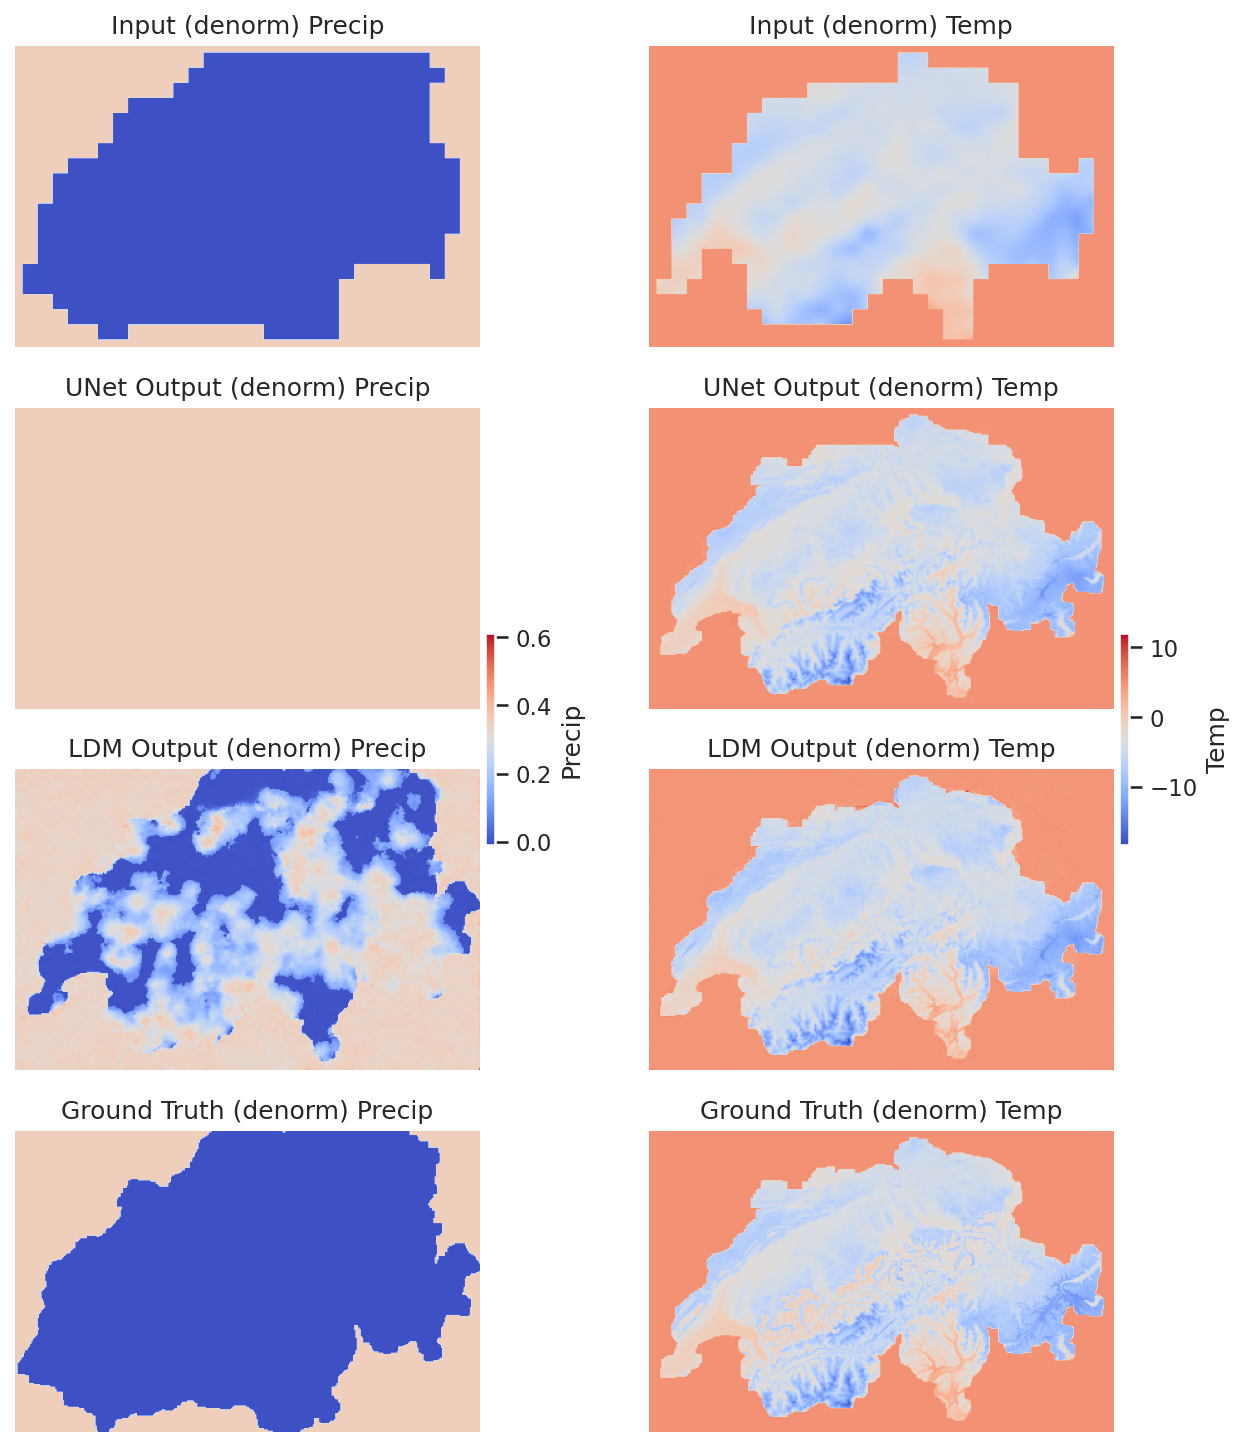

In [57]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)  # (1, C_in, H, W)
    unet_pred = unet_regr(input_sample)                      # (1, C_out, H, W)
    context = [(unet_pred, None)]
    sample_shape = unet_pred.shape[1:]                       # (C_out, H, W)
    z = torch.randn((1, *sample_shape), device=device)       # (1, C_out, H, W)

    # Dsampling
    residual, _ = sampler.sample(
        S=1000,
        batch_size=1,
        shape=sample_shape,
        conditioning=context,
        eta=0.0,
        verbose=True,
        x_T=z,
    )
    final_pred = unet_pred + residual

    final_pred_np = final_pred[0].cpu().numpy()              # (C_out, H, W)
    unet_pred_np = unet_pred[0].cpu().numpy()                # (C_out, H, W)
    input_np = input_sample[0, :unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)
    target_np = test_targets[idx][:unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)

    channel_names = ["Precip", "Temp"]
    params_list = [pr_params, temp_params]

    input_denorm = np.empty_like(input_np)
    for i, params in enumerate(params_list):
        input_denorm[i] = denorm_pr(input_np[i]) if i == 0 else denorm_temp(input_np[i], params)

    unet_pred_denorm = np.empty_like(unet_pred_np)
    for i, params in enumerate(params_list):
        unet_pred_denorm[i] = denorm_pr(unet_pred_np[i]) if i == 0 else denorm_temp(unet_pred_np[i], params)

    ldm_pred_denorm = np.empty_like(final_pred_np)
    for i, params in enumerate(params_list):
        ldm_pred_denorm[i] = denorm_pr(final_pred_np[i]) if i == 0 else denorm_temp(final_pred_np[i], params)

    target_denorm = np.empty_like(target_np)
    for i, params in enumerate(params_list):
        target_denorm[i] = denorm_pr(target_np[i]) if i == 0 else denorm_temp(target_np[i], params)

    # Debug: Print min/max to check for NaNs or constant arrays
    print("input_denorm", np.nanmin(input_denorm), np.nanmax(input_denorm))
    print("unet_pred_denorm", np.nanmin(unet_pred_denorm), np.nanmax(unet_pred_denorm))
    print("ldm_pred_denorm", np.nanmin(ldm_pred_denorm), np.nanmax(ldm_pred_denorm))
    print("target_denorm", np.nanmin(target_denorm), np.nanmax(target_denorm))

    vmins = [min(input_denorm[j].min(), unet_pred_denorm[j].min(), ldm_pred_denorm[j].min(), target_denorm[j].min()) for j in range(len(params_list))]
    vmaxs = [max(input_denorm[j].max(), unet_pred_denorm[j].max(), ldm_pred_denorm[j].max(), target_denorm[j].max()) for j in range(len(params_list))]

    # Plot
    fig, axes = plt.subplots(4, len(params_list), figsize=(5*len(params_list), 12), dpi=150)
    if len(params_list) == 1:
        axes = axes[:, np.newaxis]
    for j in range(len(params_list)):
        axes[0, j].imshow(np.flipud(input_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[0, j].set_title(f"Input (denorm) {channel_names[j]}")
        axes[0, j].axis('off')
        axes[1, j].imshow(np.flipud(unet_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[1, j].set_title(f"UNet Output (denorm) {channel_names[j]}")
        axes[1, j].axis('off')
        axes[2, j].imshow(np.flipud(ldm_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[2, j].set_title(f"LDM Output (denorm) {channel_names[j]}")
        axes[2, j].axis('off')
        axes[3, j].imshow(np.flipud(target_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[3, j].set_title(f"Ground Truth (denorm) {channel_names[j]}")
        axes[3, j].axis('off')
        cbar = fig.colorbar(axes[0, j].images[0], ax=axes[:, j], fraction=0.02, pad=0.01)
        cbar.ax.set_ylabel(channel_names[j])

    # Save to file in case notebook output is not working
    fig.savefig("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/DDIM_conditional_derived/outputs/debug_output.png")
    print("Plot saved as debug_output.png")

plt.show()